In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

import punct_utils as utils

plt.style.use('default')
plt.rcParams["text.usetex"] = True
np.random.seed(14159)

# Set parameters

In [2]:
n = 1000
L = 100

folder = 'data/'
classes = ['collie', 'tabby']
k = len(classes)

# Load features
features = [open(folder+'{}_normalized.csv'.format(cl), 'r') for cl in classes]

# Get data dimension
p = len(features[0].readline().rstrip().split(' '))
features[0].seek(0)

# Get data length
cl_len = np.zeros(k, dtype=int)
for i, f in enumerate(features):
    cl_len[i] = sum(1 for line in f)
    f.seek(0)
T = np.sum(cl_len)

setting = "$T = {} \quad n = {} \quad p = {} \quad L = {}$".format(T, n, p, L)

# Define data pipeline
true_partition = np.repeat(range(k), cl_len)
np.random.shuffle(true_partition)
get_data = lambda t: np.array(features[true_partition[t]].readline().rstrip().split(' '), dtype=float)

# Streaming

In [3]:
class_count, (lbda, w, partition_ite, time_ite) = utils.pm1_streaming(get_data, T, n, p, L, k)

100%|██████████| 20000/20000 [24:48<00:00, 13.44it/s] 


In [4]:
# Estimate classes via majority vote
partition = np.argmax(class_count, axis=1)

In [5]:
# Close files
for f in features:
    f.close()

# Results

In [6]:
# Get classification error
c_err, per, per_inv = utils.get_classif_error(k, partition, true_partition)
print("Classification error: {:.2%}".format(c_err))

# Compute classification error vs. delay
delay_c_err = np.mean(per[partition_ite[n-1:]] != np.array([true_partition[t:t+n] for t in range(T-n+1)]), axis=0)[::-1]

Classification error: 4.83%


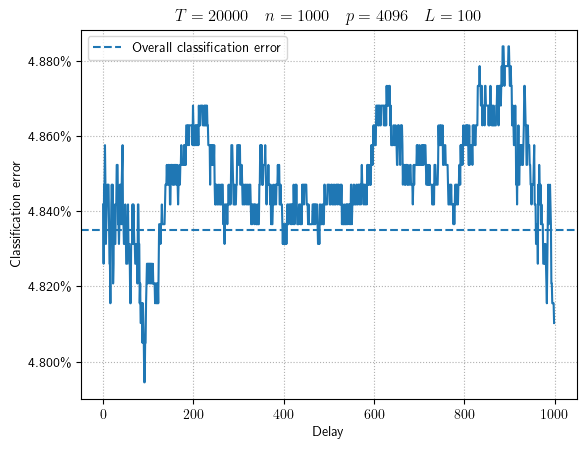

In [7]:
plt.plot(delay_c_err)
plt.axhline(y=c_err, ls='--', label="Overall classification error")
plt.grid(ls=':')
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.xlabel("Delay")
plt.ylabel("Classification error")
plt.title(setting)
plt.legend()
plt.show()

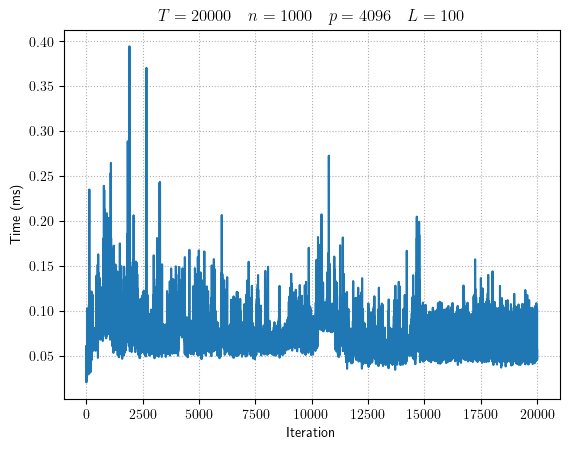

In [8]:
plt.plot(time_ite)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Time (ms)")
plt.title(setting)
plt.show()

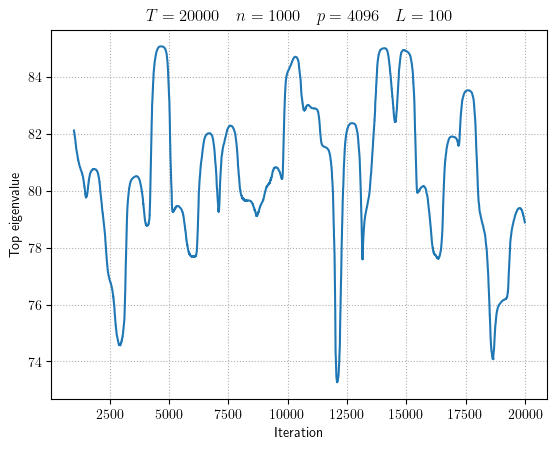

In [15]:
plt.plot(lbda)
plt.grid(ls=':')
plt.xlabel("Iteration")
plt.ylabel("Top eigenvalue")
plt.title(setting)
plt.show()

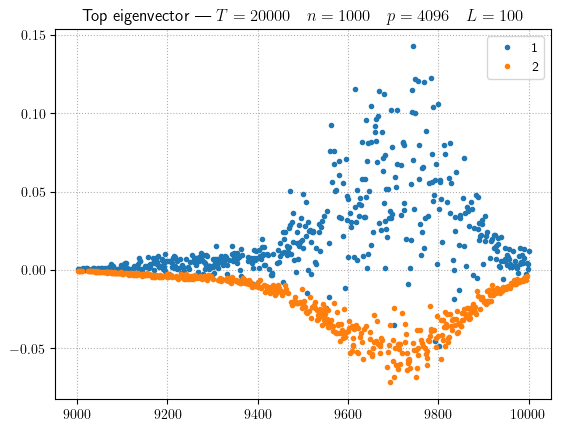

In [10]:
t = T//2

x = np.arange(max(0, t-n+1), max(n, t+1))
for j in range(k):
    color = 'C'+str(j)
    cl = (true_partition[max(0, t-n+1):t+1] == j)
    cl = np.append(cl, np.zeros(max(0, n-t-1), dtype=bool))
    plt.plot(x[cl], w[t, cl], ls='', marker='.', c=color, label=j+1, zorder=2)
plt.grid(ls=':')
plt.title("Top eigenvector | "+setting)
plt.legend()
plt.show()